# Script utilized for the Discrete Event Simulation for estimate the Port Network Capacity

# The impact of the expansion in TECON Salvador

This model utilized this librarys in Standart Python 3.6

In [1]:
# --- Librarys --- #
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ---

First, we gonna setup the capacity of resourses 

In [2]:
num_berths_300 = 1;
num_berths_611 = 2;
num_channel = 2;

In [3]:
class channel(object):
    def __init__(self, env, num_channel):
        self.env = env
        self.way = simpy.Resource(env,num_channel)

    def Navigation(self):
        yield self.env.timeout(random.randint(76,104))

class berth_300(object):
    def __init__(self, env, num_berths):
        self.env = env
        self.berth = simpy.PriorityResource(env,capacity=num_berths)
        
class berth_611(object):
    def __init__(self, env, num_berths):
        self.env = env
        self.berth = simpy.Resource(env, num_berths)
# ---

And the class of ships, which contains the caracterist of movimentation:

   1. Numeber of ship
   
   1. Cargo
   
   1. Weight
   
   1. Productivity
   
   1. Inoperable times
 
 
 For the distribuitions, is used the program EasyFit to fit real data to distribuitions, which will generete the construction model parameters

In [4]:
class Ship(object):
    def __init__(self, name, cargo):
        self.name = name
        self.cargo = cargo
        if cargo == 'contêiner':
            self.productivity = random.gauss(47.207,13.595)/60 
            self.weight = random.gammavariate(3.4766, 117.67) 
            self.measurement = 'und'
            self.pre = random.lognormvariate(-0.11457, 0.73338)*60
            self.pos = random.lognormvariate(0.56384, 0.56885)*60
        elif cargo == 'contêiner-300':
            self.productivity = random.weibullvariate(33.324,3.0315)/60
            self.weight = random.gauss(371.73,177.5)
            self.measurement = 'und'
            self.pre = random.lognormvariate(0.53083, 0.61616)*60
            self.pos = random.lognormvariate(0.34152, 0.96727)*60
        elif cargo == 'outras cargas-300':
            self.atracacao = random.gammavariate(1.3248, 34.253)*60
            self.weight = 1
            self.measurement = 't'
        else:
            self.atracacao = random.lognormvariate(4.4565, 0.82053)*60
            self.weight = 1
            self.measurement = 't'
# ---

Inicializating the lists will append the performance data and the number of simulation

In [5]:
metricas611 = []
metricas300 = []
sim = 1

Inicializating the index of demand readjustment

In [6]:
reaj = 1

Remembering the traffic process in Port 

1. Arrives of ships

1. Definition which berth will operate the cargo 

1. Requesting resourses

        1.Access Canal
    
        1.Berths
        

1. Operation process 
    
1. Access canal request to ship exit
      
1. Next ship

To run more simulations, run script below n_times you want, each run is one simulation
    The variable 'sim' inicilized above count the number of the simulation, 

Sometimes, the script will acuse a error caused by a negative delay rusulted of one of distribuitions of building parâmeters.

I didnt implement a new choice, but could be a nice improve for this script

In [7]:
#Define the operation process

def main(env,name,cargo,cn,b300,b611,db):
    
    # ---
    
    chegada = env.now
    
    # Canal request
    
    with cn.way.request() as req:
        yield req                                   # Canal queue
        yield env.timeout(random.randrange(80,100)) # Navegation time =~ 1,5 h
    
    # Ship class definition
    
    ship = Ship(name,cargo)
    
    # Berth request decison for each type of cargo
    
    if cargo == 'contêiner':
         with b611.berth.request() as r1:
            yield r1                                # Berth queue
            atracacao = env.now 
            yield env.timeout(ship.pre)             # Inoperanteble time
            inicio_operacao = env.now
            yield env.timeout((ship.weight//ship.productivity))  # Operation time
            fim_operacao = env.now
            yield env.timeout(ship.pos)             # Inoperanteble time
            desatracacao = env.now
            berth='611'
    elif cargo == 'contêiner-300':  
        with b300.berth.request(priority=0) as r2:
            yield r2                            # Berth queue    
            atracacao = env.now 
            yield env.timeout(ship.pre)         # Inoperanteble time
            inicio_operacao = env.now
            yield env.timeout((ship.weight//ship.productivity))   # Operation time
            fim_operacao = env.now
            yield env.timeout(ship.pos)         # Inoperanteble time
            desatracacao = env.now
            berth='300'
    elif cargo == 'outras cargas-300':
        with b300.berth.request(priority=1) as r2:
            yield r2
            atracacao = env.now
            inicio_operacao = env.now
            fim_operacao = env.now
            yield env.timeout(ship.atracacao) # Only atracation daley
            desatracacao = env.now
            berth='300'
    else:
        atracacao = env.now
        inicio_operacao = env.now
        fim_operacao = env.now
        yield env.timeout(ship.atracacao) # Only atracation daley
        desatracacao = env.now
        berth='only request channel'
        
    with cn.way.request() as r3:
        yield r3 # Requisição do canal e adiciona espera ao Tempo Pos Inoperante
        saida = env.now 

    db.append([name, cargo, berth, ship.weight, float(chegada), float(atracacao),float(inicio_operacao),float(fim_operacao),float(desatracacao),float(saida)])
    
# ---

# Define generation of ships setup 

def setup(env,num_berths_300,num_berths_611,num_channel,db):
    # Ships count
    i=0
    
    # Inicializating the resourses
    cn = channel(env,num_channel)
    b300 = berth_300(env,num_berths_300)
    b611 = berth_611(env,num_berths_611)
    
    # Ships arraves in var minutes
    while True:
        # Time between successive arrivals
        alpha = 2.1192#1.9384
        beta = 472.94 #8.8291
        var = (random.gammavariate(alpha, beta))*reaj
        
        # yield time
        yield env.timeout(var)
        
        # Ships name
        name = 'Navio %i' %i
        
        # Cargo choice
        cargo_choice = random.randrange(0,100)

        if (cargo_choice < 79): # 79% de contêineres para Berço 611
            cargo = 'contêiner'
        elif (79 <= cargo_choice < 87):
            cargo = 'contêiner-300' #8% de chance de contêiner - Berço 300
            prio = 0
        elif (87 <= cargo_choice < 97):
            cargo = 'outras cargas' # 11% de só acessarem o canal
        else:
            cargo = 'outras cargas-300' #2% de outras cargas - Berço 300
            prio = 1
        
        # Atracation procces called
        env.process(main(env, name, cargo,cn,b300,b611,db))
        
        # Atualized the counter of the simulation
        i += 1
#---

# Setup and Calling the process

dataBase = []; # Inicializate the atracation data base 

#---

# Criates an Environment for the simulation and CALL setup simulation
env = simpy.Environment()
env.process(setup(env,num_berths_300,num_berths_611,num_channel,dataBase))

# Execute for n_ano years, run in minutes
n_ano=1
env.run(until=n_ano*364*24*60)

# ---
# Data Analyzes

df = pd.DataFrame(np.matrix(dataBase), columns=['nome', 'carga', 'berco', 'peso', 'chegada', 'atracacao', 'inicio_operacao', 'fim_operacao', 'desatracacao','saida'])

# Conversion to 'float'
convert_dict={'peso':float,'chegada':float,'chegada':float,'atracacao':float,'inicio_operacao':float,'fim_operacao':float,'desatracacao':float,'saida':float}
df = df.astype(convert_dict)

# Calculating other indicators

df['tempo_de_espera']=(df['atracacao']-df['chegada'])/60
df['pre_operacional']=(df['inicio_operacao']-df['atracacao'])/60
df['operacional']=(df['fim_operacao']-df['inicio_operacao'])/60
df['pos_operacional']=(df['desatracacao']-df['fim_operacao'])/60
df['pos_operacional_s']=(df['saida']-df['fim_operacao'])/60
df['atracacao']=(df['desatracacao']-df['atracacao'])/60
df['produtividade']=(df['peso']/df['operacional']) # Operacional
    
# Berth 611

b611=df[df['carga'] == 'contêiner']

te_c_611 = b611[['tempo_de_espera']]
pre_c_611 = b611[['pre_operacional']]
ope_c_611 = b611[['operacional']]
pos_c_611 = b611[['pos_operacional']]
atrac_c_611 = b611[['atracacao']]
lote_c_611 = b611[['peso']]
prod_c_611 = b611[['produtividade']]

# Berth 300

b300=df[df['carga'] == 'contêiner-300']

te_c_300 = b300[['tempo_de_espera']]
pre_c_300 = b300[['pre_operacional']]
ope_c_300 = b300[['operacional']]
pos_c_300 = b300[['pos_operacional']]
atrac_c_300 = b300[['atracacao']]
lote_c_300 = b300[['peso']]
prod_c_300 = b300[['produtividade']]

# Other Cargo 300

b2300=df[df['carga'] == 'outras cargas-300']

te_c_2300 = b2300[['tempo_de_espera']]
pre_c_2300 = b2300[['pre_operacional']]
ope_c_2300 = b2300[['operacional']]
pos_c_2300 = b2300[['pos_operacional']]
atrac_c_2300 = b2300[['atracacao']]
lote_c_2300 = b2300[['peso']]
prod_c_2300 = b2300[['produtividade']]

# Building parameters

# Berth 611

lmC611 = lote_c_611.mean()
inopreC611 = pre_c_611.mean().values
inoposC611 = pos_c_611.mean().values
prodmC611 = prod_c_611.mean()
inop611=inopreC611+inoposC611

# Berth 300 - CTNER

lmC300 = lote_c_300.mean()
inopreC300 = pre_c_300.mean().values
inoposC300 = pos_c_300.mean().values
prodmC300 = prod_c_300.mean()
inop300=inopreC300+inoposC300

# Berth 300 - Outras cargas

tma2300 = atrac_c_2300.mean()

# Performance

#Berço 611

#Tempo médio de espera e Outflow
tme611 = te_c_611.mean()
out611 = te_c_611.count()

#Indice de ocupação do cais
tempo_ocupado611 = atrac_c_611.sum().values
tempo_disponivel611=num_berths_611*n_ano*364*24
p611 = (tempo_ocupado611/tempo_disponivel611)

#Berço 300

#Avarage waiting time and Outflow
tme300 = te_c_300.mean()
tme2300 = te_c_2300.mean()
out300 = te_c_300.count() 
out2300 = te_c_2300.count()
out3300 = out2300.values + out300.values

# Quay occupation
tempo_ocupado300 = atrac_c_300.sum().values
tempo_ocupado2300 = atrac_c_2300.sum().values
tempo_ocupado3300 = tempo_ocupado2300 + tempo_ocupado300

tempo_disponivel300=num_berths_300*n_ano*364*24

p300 = (tempo_ocupado300/tempo_disponivel300)
p2300 = (tempo_ocupado2300/tempo_disponivel300)
p3300 = (tempo_ocupado3300/tempo_disponivel300)

print('--- Simulação %s Concluída com Sucesso ---' % sim)

print('\nMétricas de construcao: \n')

print('Berço 611: \n')

print('Contêineres: \n')

print('Lote médio: %f unds/navio' % lmC611)
print('Produtividade média: %f und/h' % prodmC611)
print('Tempo inoperante médio pré operacional: %f horas' % inopreC611)
print('Tempo inoperante médio pós operacional: %f horas' % inoposC611)

print('\nBerço 300: \n')

print('Contêineres: \n')

print('Lote médio: %f unds/navio' % lmC300)
print('Produtividade média: %f und/h' % prodmC300)
print('Tempo inoperante médio pré operacional: %f horas' % inopreC300)
print('Tempo inoperante médio pós operacional: %f horas' % inoposC300)

print('\nOutras cargas gerais: \n')

print('Tempo de atracação: %f h' % tma2300)

print('\nMétricas de desempenho: \n')

print('Berço 611: \n')

print('Outflow: %i navios' % out611)
print('Tempo médio de espera: %f horas' % tme611)
print('Índice de ocupação (rô): %f \n' % p611)

print('Berço 300: \n')

print('Outflow: %i navios' % out3300)
print('Tempo médio de espera (Contêineres): %f horas' % tme300)
print('Tempo médio de espera (Outras Cargas): %f horas' % tme2300)
print('Índice de ocupação (rô): %f \n' % p3300)

metricas611.append([reaj,sim,float(lmC611.values),float(prodmC611.values),float(inop611),float(out611.values),float(tme611.values),float(p611)])
metricas300.append([reaj,sim,float(lmC300.values),float(prodmC300.values),float(inop300),float(out3300),float(tme300.values),float(p3300),float(tme2300.values)])
sim += 1

--- Simulação 1 Concluída com Sucesso ---

Métricas de construcao: 

Berço 611: 

Contêineres: 

Lote médio: 408.702471 unds/navio
Produtividade média: 46.843255 und/h
Tempo inoperante médio pré operacional: 1.262422 horas
Tempo inoperante médio pós operacional: 2.001726 horas

Berço 300: 

Contêineres: 

Lote médio: 356.840815 unds/navio
Produtividade média: 31.455768 und/h
Tempo inoperante médio pré operacional: 2.073335 horas
Tempo inoperante médio pós operacional: 2.141876 horas

Outras cargas gerais: 

Tempo de atracação: 55.878115 h

Métricas de desempenho: 

Berço 611: 

Outflow: 409 navios
Tempo médio de espera: 1.716799 horas
Índice de ocupação (rô): 0.304415 

Berço 300: 

Outflow: 59 navios
Tempo médio de espera (Contêineres): 7.333247 horas
Tempo médio de espera (Outras Cargas): 4.557120 horas
Índice de ocupação (rô): 0.218908 



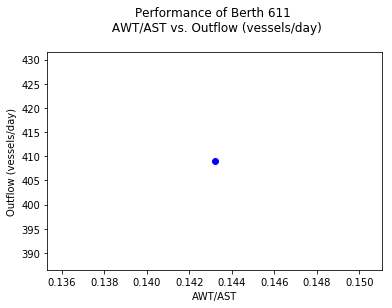

In [10]:
# 611
m611 = pd.DataFrame(metricas611,columns=['Variação_TCS', 'N_sim', 'Lote_medio', 'Produtividade', 'T_Inoperante', 'Outflow', 'AWT', 'p'])

m611['AST']=((m611['Lote_medio']/m611['Produtividade'])+m611['T_Inoperante'])
m611['WT/ST']=(m611['AWT']/m611['AST'])

with pd.ExcelWriter('metricas_611.xlsx') as writer:  # doctest: +SKIP
    m611.to_excel(writer)

plt.plot(m611['WT/ST'],m611['Outflow'],'bo')
plt.xlabel('AWT/AST')
plt.ylabel('Outflow (vessels/day)')
plt.title('Performance of Berth 611 \n AWT/AST vs. Outflow (vessels/day)\n')
plt.show()

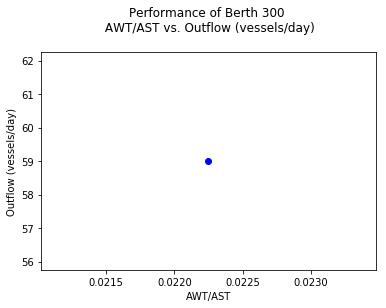

In [11]:
# 300
m300 = pd.DataFrame(metricas300,columns=['Variação_TCS', 'N_sim', 'Lote_medio', 'Produtividade', 'T_Inoperante', 'Outflow', 'AWT_C', 'p','AWT_O'])

m300['AST']=((m300['Lote_medio']-m300['Produtividade'])+m300['T_Inoperante'])
m300['WT/ST']=(m300['AWT_C']/m300['AST'])

with pd.ExcelWriter('metricas_300.xlsx') as writer2:  # doctest: +SKIP
    m300.to_excel(writer2)

plt.plot(m300['WT/ST'],m300['Outflow'],'bo')
plt.xlabel('AWT/AST')
plt.ylabel('Outflow (vessels/day)')
plt.title('Performance of Berth 300 \n AWT/AST vs. Outflow (vessels/day)\n')
plt.show()